In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import numpy as np
import torchvision
from torchvision import datasets, models
from torchvision import transforms
from torchvision.models import ResNet18_Weights
from torchvision.models import ResNet101_Weights
from torchvision.models import ResNet152_Weights
from torch.optim.lr_scheduler import StepLR
import time
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image

In [2]:
print(torch.cuda.is_available())
print(torch.__version__)

False
2.1.0+cpu


In [3]:
transforms_wt = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

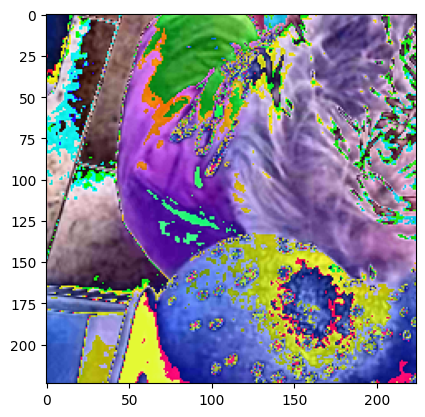

In [4]:
orig_set = datasets.ImageFolder(
    root='./data/test_03',
    transform=transforms_wt
)
data, label = orig_set[100]
transform_test = T.ToPILImage()
plt.imshow(transform_test(data))


In [5]:
orig_set.classes

['duoballs', 'trigger']

In [6]:
len(orig_set)

4843

In [7]:
data, label = orig_set[0]
print(data.size())

torch.Size([3, 224, 224])


In [8]:
import torch
from torch.utils.data import random_split, DataLoader

data_loader = DataLoader(orig_set, batch_size=len(orig_set), shuffle=True)

# Define the dataset size
dataset_size = len(orig_set)

# Calculate the sizes for training, validation, and test sets
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset into training, validation, and test sets
train_set, val_set, test_set = random_split(orig_set, [train_size, val_size, test_size])

In [9]:
val_data, val_label = val_set[1]
print(val_data.size())

torch.Size([3, 224, 224])


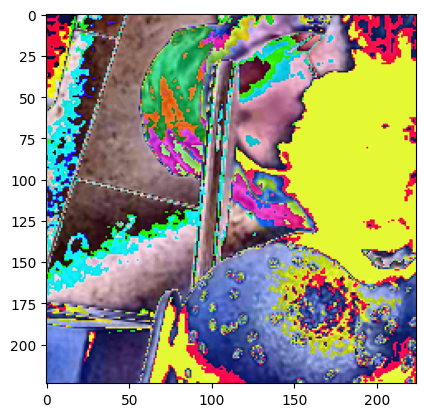

In [10]:
transform = T.ToPILImage()
plt.imshow(transform(val_data))

In [11]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=8,
    shuffle=True,
    num_workers=16
)

C:\Users\DK602\AppData\Roaming\Python\Python311\site-packages\torch\utils\data\dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [12]:
val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=8,
    shuffle=True,
    num_workers=16
)

In [13]:
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=8,
    shuffle=True,
    num_workers=16
)

In [14]:
model = models.resnet152(weights=ResNet152_Weights.IMAGENET1K_V2)

print(model.fc)

Linear(in_features=2048, out_features=1000, bias=True)


num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)
print(model.fc)

In [15]:
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 2048),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(2048,1024),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(1024,500),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(500,2)
)
print(model.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=2048, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=2048, out_features=1024, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=1024, out_features=500, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=500, out_features=2, bias=True)
)


In [16]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

In [18]:
import sys
sys.path.append('C:/Users/DK602/MCI/TT/tensionterminator/framework')
from framework import FrameworkLogger
from main_func_pyt_sample import main_train_func

input_args = [train_loader, val_loader, model, criterion, optimizer, exp_lr_scheduler, device]

# Modell trainieren
logger = FrameworkLogger(2, model, main_train_func, input_args, "primin_pytorch")
logger.train_model_pyt()
#logger.generate_statistics()

Epoch 0


C:\Users\DK602\AppData\Roaming\Python\Python311\site-packages\torch\utils\data\dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 0: Train: Loss: 0.0326 Acc: 0.9650 Val: Loss: 5.2823 Acc: 0.7335
{'loss': 0.03258685031083252, 'accuracy': 0.9649725556373596, 'val_loss': 5.28231119253665, 'val_accuracy': 0.7334710743801653}
Epoch 0 took 2751.01 seconds
Epoch 1
Epoch: 1: Train: Loss: 0.0439 Acc: 0.7988 Val: Loss: 23.1843 Acc: 0.7335
{'loss': 0.043856307839882654, 'accuracy': 0.7987637519836426, 'val_loss': 23.18433453843829, 'val_accuracy': 0.7334710743801653}
Epoch 1 took 2245.13 seconds
Training time: 2245.13 seconds


TypeError: conv2d() received an invalid combination of arguments - got (list, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!list of [Tensor, Tensor]!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!list of [Tensor, Tensor]!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)


In [22]:
start_time = time.time()

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()/inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)/inputs.size(0)


    exp_lr_scheduler.step()
    train_epoch_loss = running_loss / len(train_loader)
    train_epoch_acc = running_corrects / len(train_loader)

    model.eval()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in (val_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() / inputs.size(0)
        running_corrects += torch.sum(preds == labels.data) / inputs.size(0)

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = running_corrects.double() / len(val_loader)
    print(f"Epoch: {epoch}: Train: Loss: {train_epoch_loss:.4f} Acc: {train_epoch_acc:.4f} Val: Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

end_time = time.time()
print("Time:", end_time - start_time)

KeyboardInterrupt: 

In [34]:
torch.save(model.state_dict(), "./trigger_duoballs_moddel_03.pt")

test_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=4,
    shuffle=True,
    num_workers=16
)

In [35]:
num_correct = 0.0
for inputs, labels in test_loader:
    model.eval()
    inputs = inputs.to(device)
    labels = labels.to(device)
    predict_label = model(inputs)
    _, predicted = torch.max(predict_label,1)
    num_correct += (predicted == labels).float().sum()

    accuracy = num_correct/(len(test_loader)*test_loader.batch_size)

    print(len(test_loader), test_loader.batch_size)
    print("Test Accuracy: {}".format(accuracy))

122 8
Test Accuracy: 0.0071721309795975685
122 8
Test Accuracy: 0.012295082211494446
122 8
Test Accuracy: 0.01741803251206875
122 8
Test Accuracy: 0.02459016442298889
122 8
Test Accuracy: 0.031762294471263885
122 8
Test Accuracy: 0.03586065396666527
122 8
Test Accuracy: 0.04200819507241249
122 8
Test Accuracy: 0.048155736178159714
122 8
Test Accuracy: 0.052254099398851395
122 8
Test Accuracy: 0.05737704783678055
122 8
Test Accuracy: 0.06352458894252777
122 8
Test Accuracy: 0.07172130793333054
122 8
Test Accuracy: 0.07786884903907776
122 8
Test Accuracy: 0.08504098653793335
122 8
Test Accuracy: 0.08913934230804443
122 8
Test Accuracy: 0.09528688341379166
122 8
Test Accuracy: 0.10143442451953888
122 8
Test Accuracy: 0.10860655456781387
122 8
Test Accuracy: 0.1147540956735611
122 8
Test Accuracy: 0.12192623317241669
122 8
Test Accuracy: 0.12602458894252777
122 8
Test Accuracy: 0.13114753365516663
122 8
Test Accuracy: 0.13729508221149445
122 8
Test Accuracy: 0.1424180269241333
122 8
Test A

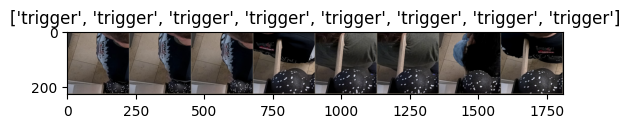

In [36]:
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.show()

def print_grid():
    inputs, classes = next(iter(test_loader))
    out = torchvision.utils.make_grid(inputs)
    class_names = orig_set.classes

    outputs = model(inputs.to(device))
    _, preds = torch.max(outputs, 1)

    imshow(out, title=[class_names[x] for x in preds])

print_grid()